# 01 - Exploratory Data Analysis

This notebook performs a focused EDA on the news dataset you placed in `data/`. It computes headline-length statistics, top publishers, daily publication frequency, and extracts the most common words in headlines.

Notes:
- Expected file: `data/news.csv` (columns: `headline`, `publisher`, `date`, `stock`), but the loader will attempt to find a suitable CSV automatically.
- Outputs are written to `output/` (CSV and PNG files).

In [1]:
# Imports and plotting setup
import os, glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
sns.set(style="whitegrid")

# helper to ensure output dir exists
OUT = Path('output')
OUT.mkdir(exist_ok=True)

In [4]:
# Try to locate the news CSV inside data/
data_dir = Path('/home/karanos/kiam/week1/Data')
csv_candidates = list(data_dir.glob('*.csv')) if data_dir.exists() else []
print('Found CSV files in data/:', [p.name for p in csv_candidates])

def find_news_csv(candidates):
    # prefer filenames containing 'news' or 'head'
    for p in candidates:
        name = p.name.lower()
        if 'news' in name or 'headline' in name or 'head' in name:
            return p
    # fallback: pick first csv that contains a 'headline' column
    for p in candidates:
        try:
            sample = pd.read_csv(p, nrows=5)
            if any(c.lower()=='headline' for c in sample.columns):
                return p
        except Exception:
            continue
    return None

news_csv = find_news_csv(csv_candidates)
news_csv

Found CSV files in data/: ['raw_analyst_ratings.csv']


PosixPath('/home/karanos/kiam/week1/Data/raw_analyst_ratings.csv')

In [5]:
# Load the news dataset
if news_csv is None:
    raise FileNotFoundError('Could not find a suitable news CSV in data/. Please ensure news.csv is present.')

df = pd.read_csv(news_csv, parse_dates=['date'], infer_datetime_format=True)

/tmp/ipykernel_18618/2050517564.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(news_csv, parse_dates=['date'], infer_datetime_format=True)


In [6]:
# Quick peek and basic cleaning
print('shape:', df.shape)
display(df.head(5))

# ensure required columns exist (case-insensitive matching)
cols = {c.lower(): c for c in df.columns}
for req in ['headline','publisher','date']:
    if req not in cols:
        raise KeyError(f'Missing required column: {req} (found: {list(df.columns)})')
# normalize column names for ease of use
df = df.rename(columns={cols['headline']: 'headline', cols['publisher']: 'publisher', cols['date']: 'date'})
df = df.dropna(subset=['headline'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['date_only'] = df['date'].dt.date
df['headline_len'] = df['headline'].astype(str).str.len()
df.shape

shape: (1407328, 6)


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


(55987, 8)

count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_len, dtype: float64


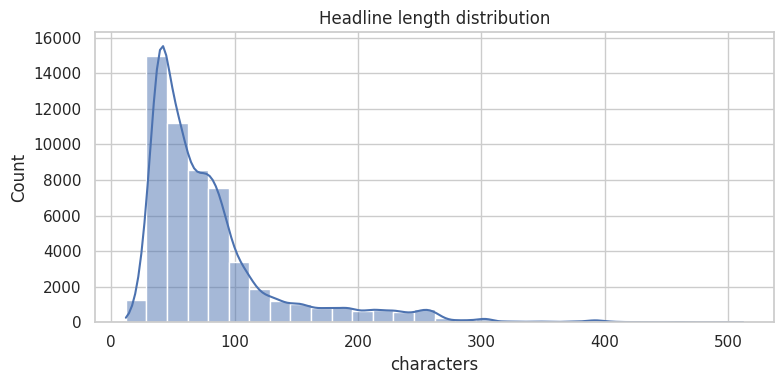

In [7]:
# Headline length statistics and histogram
length_stats = df['headline_len'].describe()
print(length_stats)
length_stats.to_csv(OUT / 'headline_length_stats.csv')

plt.figure(figsize=(8,4))
sns.histplot(df['headline_len'], bins=30, kde=True)
plt.title('Headline length distribution')
plt.xlabel('characters')
plt.tight_layout()
plt.savefig(OUT / 'headline_length_hist.png')
plt.show()

publisher
Benzinga Newsdesk          14750
Lisa Levin                 12408
ETF Professor               4362
Paul Quintaro               4212
Benzinga Newsdesk           3177
Benzinga Insights           2332
Vick Meyer                  2128
Charles Gross               1790
Hal Lindon                  1470
Benzinga_Newsdesk           1239
Eddie Staley                1003
vishwanath@benzinga.com      924
Shanthi Rexaline             887
Monica Gerson                611
Wayne Duggan                 465
Nelson Hem                   345
Jayson Derrick               337
Craig Jones                  310
luke@benzinga.com            271
Javier Hasse                 250
Name: count, dtype: int64

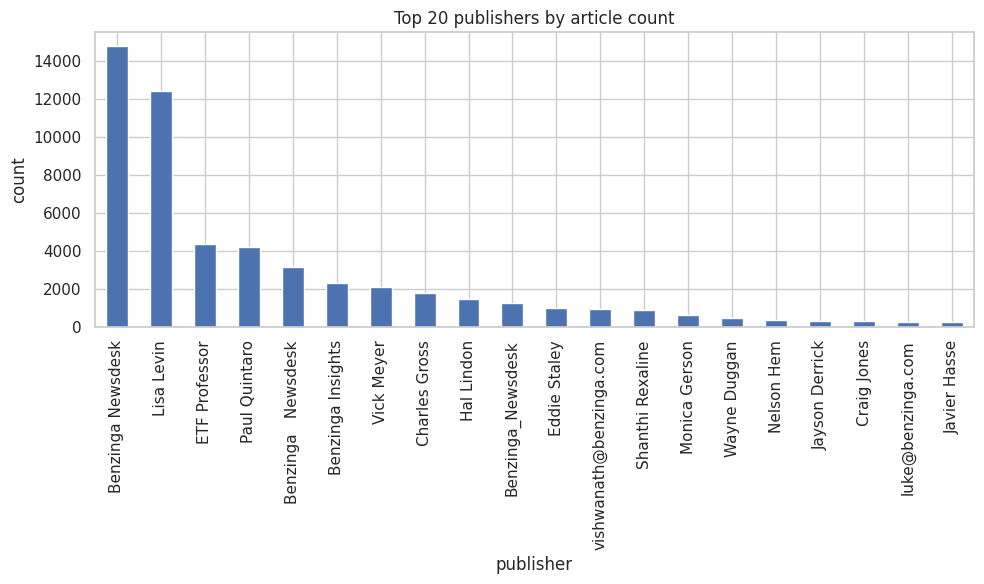

In [8]:
# Top publishers
pub_counts = df['publisher'].value_counts()
display(pub_counts.head(20))
pub_counts.head(50).to_csv(OUT / 'top_publishers.csv')

plt.figure(figsize=(10,6))
pub_counts.head(20).plot(kind='bar')
plt.title('Top 20 publishers by article count')
plt.ylabel('count')
plt.tight_layout()
plt.savefig(OUT / 'top_publishers.png')
plt.show()

date
2011-04-27 00:00:00-04:00    1
2011-04-28 00:00:00-04:00    2
2011-04-29 00:00:00-04:00    2
2011-04-30 00:00:00-04:00    1
2011-05-01 00:00:00-04:00    1
2011-05-02 00:00:00-04:00    9
2011-05-03 00:00:00-04:00    3
2011-05-04 00:00:00-04:00    0
2011-05-05 00:00:00-04:00    3
2011-05-06 00:00:00-04:00    3
2011-05-07 00:00:00-04:00    2
2011-05-08 00:00:00-04:00    0
2011-05-09 00:00:00-04:00    3
2011-05-10 00:00:00-04:00    0
2011-05-11 00:00:00-04:00    3
2011-05-12 00:00:00-04:00    1
2011-05-13 00:00:00-04:00    4
2011-05-14 00:00:00-04:00    0
2011-05-15 00:00:00-04:00    1
2011-05-16 00:00:00-04:00    4
Freq: D, Name: headline, dtype: int64

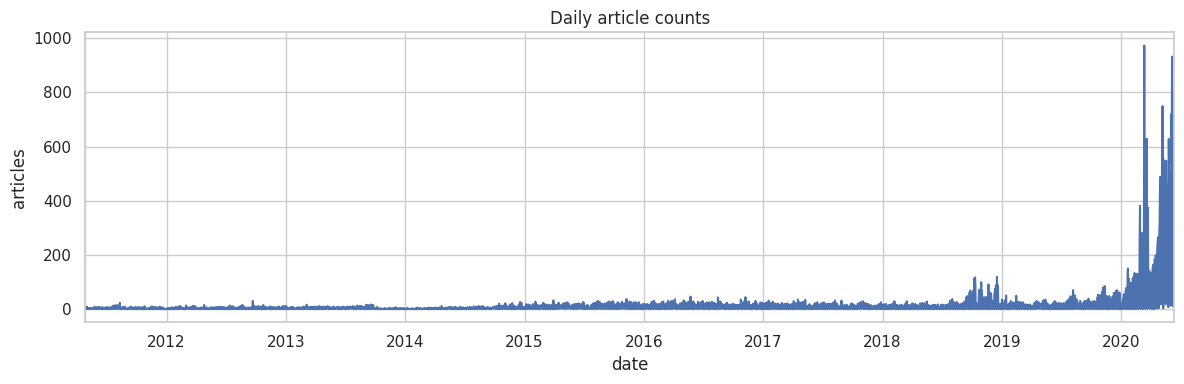

In [9]:
# Publications over time (daily)
pub_ts = df.set_index('date').resample('D')['headline'].count().fillna(0).astype(int)
display(pub_ts.head(20))
pub_ts.to_csv(OUT / 'publications_over_time_daily.csv')
plt.figure(figsize=(12,4))
pub_ts.plot()
plt.title('Daily article counts')
plt.ylabel('articles')
plt.tight_layout()
plt.savefig(OUT / 'publications_over_time.png')
plt.show()

In [10]:
# Simple keyword extraction from headlines (naive)
# tokenize, lower, remove short tokens and numbers
text = ' '.join(df['headline'].astype(str).tolist())
tokens = re.findall(r"\b[a-zA-Z]{3,}\b", text.lower())
# optional: remove common english stopwords if available
try:
    import nltk
    from nltk.corpus import stopwords
    nltk.data.find('corpora/stopwords')
    stops = set(w.lower() for w in stopwords.words('english'))
except Exception:
    stops = set(['the','and','for','with','that','this','from','are','was','has'])
filtered = [t for t in tokens if t not in stops]
top_words = Counter(filtered).most_common(30)
display(top_words[:20])
pd.DataFrame(top_words, columns=['word','count']).to_csv(OUT / 'top_headline_words.csv', index=False)

[('stocks', 12794),
 ('week', 9029),
 ('shares', 8393),
 ('trading', 6575),
 ('hit', 5902),
 ('eps', 5531),
 ('market', 5482),
 ('price', 5046),
 ('companies', 4778),
 ('target', 4676),
 ('several', 4650),
 ('sales', 4429),
 ('higher', 4271),
 ('estimate', 3818),
 ('lows', 3741),
 ('session', 3394),
 ('maintains', 3266),
 ('new', 3110),
 ('yesterday', 3067),
 ('which', 3035)]

## Next steps

- Use `notebooks/02-Indicators.ipynb` to prepare price indicators (SMA/RSI/MACD).
- Use `notebooks/03-Sentiment-Correlation.ipynb` to score headlines and compute correlations with daily returns.
- If you want, run `python -m src.run_eda` from the repository root to reproduce these outputs non-interactively.